In [1]:
!nvidia-smi

Thu Mar  3 18:12:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 35%   52C    P0    53W / 151W |    381MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from transformers import create_optimizer

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
df_train = pd.read_csv('../data/train_cleaned.zip', compression='zip')
df_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."


In [5]:
df_test = pd.read_csv('../data/test_cleaned.zip', compression='zip')
df_test.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank you for understanding i think very highl...,"['thank', 'you', 'for', 'understanding', 'i', ...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highli', 'wo...","[('thank', 'NN'), ('understanding', 'VBG'), ('...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highly', 'wo...","[('thank', 'understanding'), ('understanding',..."


In [6]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: str(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: str(x))

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate
  
  https://tfhub.dev/google/collections/bert/1

In [7]:
#Input Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#Preprocessing Layer
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

#Encoder Layer
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/2", trainable=True, name='smallBERT_encoder')
outputs = encoder(encoder_inputs)

#Classification Layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(768, activation='relu', name='pre_classifier')(net)
net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)

model = tf.keras.Model(inputs=[text_input], outputs=[net])

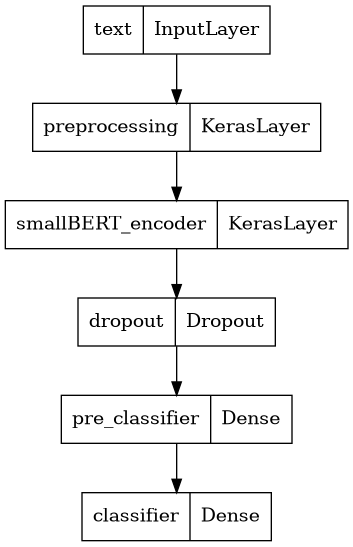

In [8]:
tf.keras.utils.plot_model(model)

In [9]:
df_sample = df_train.sample(frac=1, replace=False, random_state=42)
X = df_sample.clean_text
y = df_sample[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((127656,), (31915,))

In [10]:
X_test = df_test.clean_text
y_test = df_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_test.shape

(63978,)

In [13]:
batch_size = 32
epochs  = 5
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['acc',
                           tf.keras.metrics.AUC(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()]
             )

In [14]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                       epochs=epochs)

Epoch 1/5
3990/3990 [==============================] - 1262s 316ms/step - loss: 0.0502 - acc: 0.8922 - auc_1: 0.9798 - precision_1: 0.8042 - recall_1: 0.6546 - val_loss: 0.0427 - val_acc: 0.9931 - val_auc_1: 0.9876 - val_precision_1: 0.7834 - val_recall_1: 0.7563
Epoch 2/5
3990/3990 [==============================] - 1297s 325ms/step - loss: 0.0393 - acc: 0.9458 - auc_1: 0.9884 - precision_1: 0.8269 - recall_1: 0.7317 - val_loss: 0.0426 - val_acc: 0.9826 - val_auc_1: 0.9848 - val_precision_1: 0.7654 - val_recall_1: 0.7947
Epoch 3/5
3990/3990 [==============================] - 1328s 333ms/step - loss: 0.0347 - acc: 0.9298 - auc_1: 0.9913 - precision_1: 0.8374 - recall_1: 0.7660 - val_loss: 0.0438 - val_acc: 0.9921 - val_auc_1: 0.9872 - val_precision_1: 0.7261 - val_recall_1: 0.8344
Epoch 4/5
3990/3990 [==============================] - 1309s 328ms/step - loss: 0.0310 - acc: 0.8790 - auc_1: 0.9935 - precision_1: 0.8496 - recall_1: 0.7942 - val_loss: 0.0433 - val_acc: 0.9144 - val_auc_1: 

In [15]:
history.history

{'loss': [0.05024217069149017,
  0.03930111229419708,
  0.0347023569047451,
  0.031013354659080505,
  0.028503071516752243],
 'acc': [0.8922337889671326,
  0.9458231329917908,
  0.9297800064086914,
  0.8790186047554016,
  0.8564736247062683],
 'auc_1': [0.9797890186309814,
  0.9883784055709839,
  0.9913325905799866,
  0.9934906959533691,
  0.9945937395095825],
 'precision_1': [0.804248571395874,
  0.8269471526145935,
  0.8374472856521606,
  0.8496197462081909,
  0.85776287317276],
 'recall_1': [0.654615581035614,
  0.7316733598709106,
  0.7660045623779297,
  0.7942269444465637,
  0.8119819760322571],
 'val_loss': [0.04267200082540512,
  0.042560603469610214,
  0.043762288987636566,
  0.04333695024251938,
  0.04396449029445648],
 'val_acc': [0.9931380152702332,
  0.9826100468635559,
  0.9921040534973145,
  0.9143663048744202,
  0.8871690630912781],
 'val_auc_1': [0.9875615835189819,
  0.9847768545150757,
  0.9872186779975891,
  0.9820537567138672,
  0.9811323285102844],
 'val_precision_

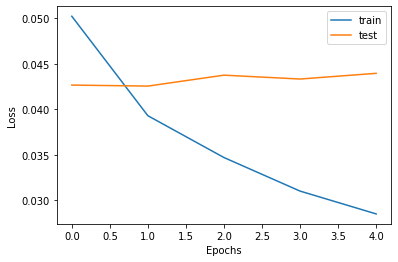

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

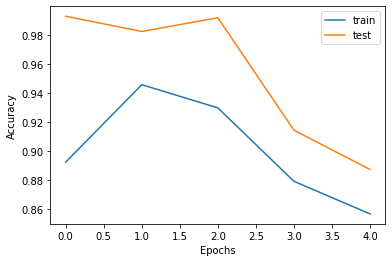

In [51]:
#Accuracy non affidabile !!!!
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

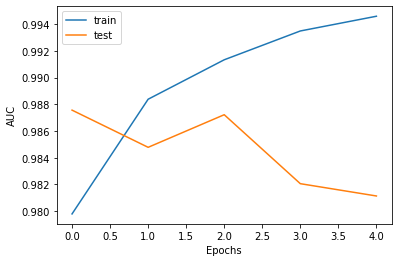

In [46]:
plt.plot(history.history['auc_1'], label='train')
plt.plot(history.history['val_auc_1'], label='test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

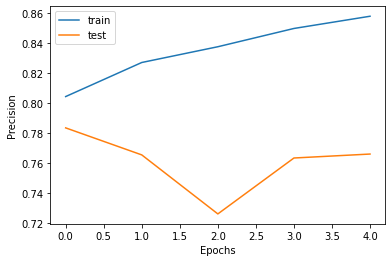

In [48]:
plt.plot(history.history['precision_1'], label='train')
plt.plot(history.history['val_precision_1'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

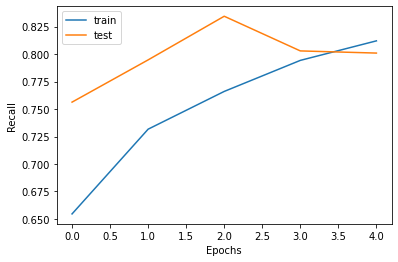

In [50]:
plt.plot(history.history['recall_1'], label='train')
plt.plot(history.history['val_recall_1'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [16]:
predictions = model.predict(X_test)
y_pred = np.round(predictions)

In [24]:
print(classification_report(y_test, y_pred, target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate']))

               precision    recall  f1-score   support

        toxic       0.53      0.89      0.67      6090
 severe_toxic       0.33      0.59      0.42       367
      obscene       0.58      0.82      0.68      3691
       threat       0.44      0.64      0.52       211
       insult       0.59      0.78      0.67      3427
identity_hate       0.56      0.71      0.62       712

    micro avg       0.55      0.83      0.66     14498
    macro avg       0.50      0.74      0.60     14498
 weighted avg       0.55      0.83      0.66     14498
  samples avg       0.07      0.08      0.07     14498



In [20]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[53100,  4788],
        [  647,  5443]],

       [[63162,   449],
        [  150,   217]],

       [[58076,  2211],
        [  650,  3041]],

       [[63593,   174],
        [   76,   135]],

       [[58692,  1859],
        [  741,  2686]],

       [[62870,   396],
        [  210,   502]]])

In [22]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.8687361280440151


In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [40]:
print(roc_auc["micro"])

0.9837935867827698


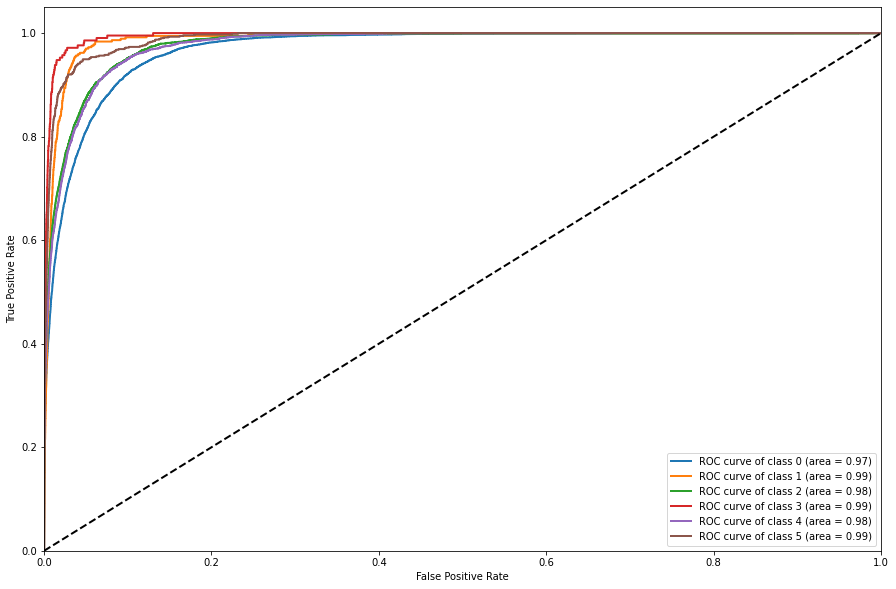

In [42]:
plt.figure(figsize=(15,10))
for i in range(6):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()